# Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import TableOne
import warnings
from sklearn.model_selection import train_test_split
import joblib
import seaborn as sns
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")


# Load all data


In [9]:
# Loading original datasets
original_data = pd.read_csv('../preprocessed_data.csv')

# Loading altered datasets
data_altered_20_percent_african_american= pd.read_csv('../data_altered_20_percent_african_american.csv')
data_altered_80_percent_female = pd.read_csv('../data_altered_80_percent_female.csv')

# Choose the dataset you want to experiment with and split the variables

In [10]:
# choose the data set to experiment with
data = data_altered_20_percent_african_american

# Drop the 'gender_M' and 'ethnicity_Other' columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = data.drop('hospital_death', axis=1)  # Features
y = data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (62060, 38)
X_test shape: (15515, 38)
y_train shape: (62060,)
y_test shape: (15515,)


# Loading the models for comparison

In [11]:
# Random Forest Original
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")

# Random Forest Altered 20% African American
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")

# Random Forest Altered 80% Female

# Choose the model you want to explore with

In [12]:
# Choose the model you want to explore
model_of_interest = altered_rf_loaded  # Any model you want to explore

## Plot differences in performance by subgroups for your chosen model

AUROC by Ethnicity: {'ethnicity_African American': np.float64(0.8291063030946603), 'ethnicity_Asian': np.float64(0.856619384416961), 'ethnicity_Caucasian': np.float64(0.8578030540192703), 'ethnicity_Hispanic': np.float64(0.8202210695441743), 'ethnicity_Native American': np.float64(0.8370503575631933)}
AUROC by Gender: {'Female': np.float64(0.8313716588847115), 'Male': np.float64(0.8473100764671282)}
AUROC by Age: {'age_cat_10-19': np.float64(0.9240601503759398), 'age_cat_20-29': np.float64(0.871122599704579), 'age_cat_30-39': np.float64(0.8890459240647682), 'age_cat_40-49': np.float64(0.8651868510739479), 'age_cat_50-59': np.float64(0.8676700712143928), 'age_cat_60-69': np.float64(0.8253469307265403), 'age_cat_70-79': np.float64(0.8147746371275784), 'age_cat_80-89': np.float64(0.7678623973463874)}
AUROC by BMI: {'bmi_cat_10-14': np.float64(0.74375), 'bmi_cat_15-19': np.float64(0.7815758193241636), 'bmi_cat_20-24': np.float64(0.8186928400844466), 'bmi_cat_25-29': np.float64(0.8556624439

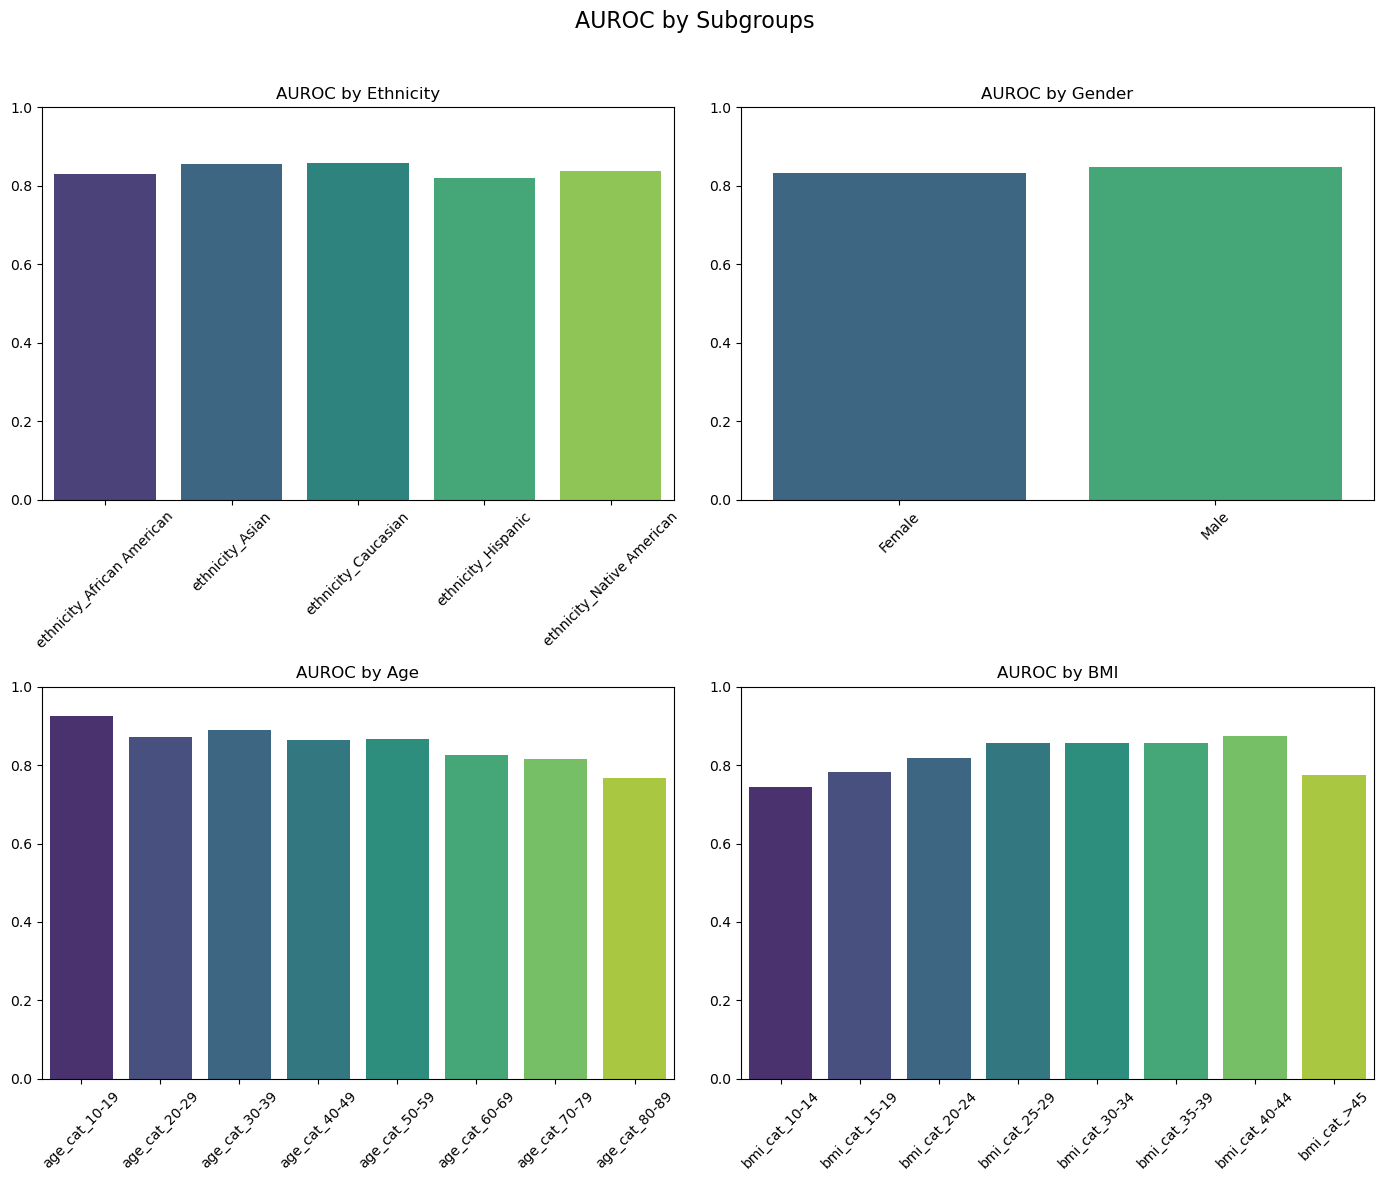

In [13]:

# Same helper function for ethnicity / age / BMI
def calculate_auroc_by_group(data, group_columns, model, X_test, y_test):
    auroc_scores_else = {}
    for group_column in group_columns:
        # Filter the test set for the current group
        group_indices = (X_test[group_column] == 1)
        X_group = X_test[group_indices]
        y_group = y_test[group_indices]
        
        # Calculate AUROC if the group has enough samples
        if len(y_group) > 0:
            y_pred_proba_group = model.predict_proba(X_group)[:, 1]
            auroc_scores_else[group_column] = roc_auc_score(y_group, y_pred_proba_group)
    
    return auroc_scores_else

# Helper function for a single gender column (by default "gender_F")
def calculate_auroc_for_gender(model, X_test, y_test, gender_column='gender_F'):
    auroc_scores_by_gender = {}

    # Females
    female_indices = (X_test[gender_column] == 1)
    X_female = X_test[female_indices]
    y_female = y_test[female_indices]
    if len(y_female) > 0:
        y_pred_proba_female = model.predict_proba(X_female)[:, 1]
        auroc_scores_by_gender['Female'] = roc_auc_score(y_female, y_pred_proba_female)

    # Males
    male_indices = (X_test[gender_column] == 0)
    X_male = X_test[male_indices]
    y_male = y_test[female_indices == False]  # or simply y_test[male_indices]
    if len(y_male) > 0:
        y_pred_proba_male = model.predict_proba(X_male)[:, 1]
        auroc_scores_by_gender['Male'] = roc_auc_score(y_male, y_pred_proba_male)

    return auroc_scores_by_gender

# Example subgroup columns
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

age_columns = [
    'age_cat_10-19', 'age_cat_20-29', 'age_cat_30-39',
    'age_cat_40-49', 'age_cat_50-59', 'age_cat_60-69',
    'age_cat_70-79', 'age_cat_80-89'
]

bmi_columns = [
    'bmi_cat_10-14', 'bmi_cat_15-19', 'bmi_cat_20-24', 'bmi_cat_25-29',
    'bmi_cat_30-34', 'bmi_cat_35-39', 'bmi_cat_40-44', 'bmi_cat_>45'
]

data['gender_M'] = 1 - data['gender_F']  # only if "gender_F" exists!

# Now calculate AUROC for each subgroup
auroc_by_ethnicity = calculate_auroc_by_group(
    data, ethnicity_columns, model_of_interest, X_test, y_test
)

# For gender, we have a simpler specialized function:
auroc_by_gender = calculate_auroc_for_gender(
    model_of_interest, X_test, y_test, gender_column='gender_F'
)

auroc_by_age = calculate_auroc_by_group(
    data, age_columns, model_of_interest, X_test, y_test
)

auroc_by_bmi = calculate_auroc_by_group(
    data, bmi_columns,model_of_interest, X_test, y_test
)

print("AUROC by Ethnicity:", auroc_by_ethnicity)
print("AUROC by Gender:", auroc_by_gender)
print("AUROC by Age:", auroc_by_age)
print("AUROC by BMI:", auroc_by_bmi)

# Finally, plot the four sets of results in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('AUROC by Subgroups', fontsize=16)

# 1) Ethnicity
sns.barplot(
    ax=axes[0, 0],
    x=list(auroc_by_ethnicity.keys()),
    y=list(auroc_by_ethnicity.values()),
    palette='viridis'
)
axes[0, 0].set_title('AUROC by Ethnicity')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2) Gender
sns.barplot(
    ax=axes[0, 1],
    x=list(auroc_by_gender.keys()),
    y=list(auroc_by_gender.values()),
    palette='viridis'
)
axes[0, 1].set_title('AUROC by Gender')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3) Age
sns.barplot(
    ax=axes[1, 0],
    x=list(auroc_by_age.keys()),
    y=list(auroc_by_age.values()),
    palette='viridis'
)
axes[1, 0].set_title('AUROC by Age')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4) BMI
sns.barplot(
    ax=axes[1, 1],
    x=list(auroc_by_bmi.keys()),
    y=list(auroc_by_bmi.values()),
    palette='viridis'
)
axes[1, 1].set_title('AUROC by BMI')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [14]:
import pandas as pd



# Calculate AUROC for  origil data
auroc_by_ethnicity_dropnan = calculate_auroc_by_group(
    original_data, ethnicity_columns, original_rf_loaded, X_test, y_test
)
auroc_by_gender_dropnan = calculate_auroc_for_gender(
    original_rf_loaded, X_test, y_test, gender_column='gender_F'
)
auroc_by_age_dropnan = calculate_auroc_by_group(
    original_data, age_columns, original_rf_loaded, X_test, y_test
)
auroc_by_bmi_dropnan = calculate_auroc_by_group(
    original_data, bmi_columns, original_rf_loaded, X_test, y_test
)

# Create DataFrames for each set of AUROC scores
ethnicity_df = pd.DataFrame({
    'Ethnicity': list(auroc_by_ethnicity.keys()),
    'AUROC_Altered': list(auroc_by_ethnicity.values()),
    'AUROC_Dropnan': list(auroc_by_ethnicity_dropnan.values())
})

gender_df = pd.DataFrame({
    'Gender': list(auroc_by_gender.keys()),
    'AUROC_Altered': list(auroc_by_gender.values()),
    'AUROC_Dropnan': list(auroc_by_gender_dropnan.values())
})

age_df = pd.DataFrame({
    'Age': list(auroc_by_age.keys()),
    'AUROC_Altered': list(auroc_by_age.values()),
    'AUROC_Dropnan': list(auroc_by_age_dropnan.values())
})

bmi_df = pd.DataFrame({
    'BMI': list(auroc_by_bmi.keys()),
    'AUROC_Altered': list(auroc_by_bmi.values()),
    'AUROC_Dropnan': list(auroc_by_bmi_dropnan.values())
})

# Display the DataFrames
print("AUROC by Ethnicity:")
print(ethnicity_df)

print("\nAUROC by Gender:")
print(gender_df)

print("\nAUROC by Age:")
print(age_df)

print("\nAUROC by BMI:")
print(bmi_df)

AUROC by Ethnicity:
                    Ethnicity  AUROC_Altered  AUROC_Dropnan
0  ethnicity_African American       0.829106       0.832887
1             ethnicity_Asian       0.856619       0.861983
2         ethnicity_Caucasian       0.857803       0.847220
3          ethnicity_Hispanic       0.820221       0.827274
4   ethnicity_Native American       0.837050       0.846515

AUROC by Gender:
   Gender  AUROC_Altered  AUROC_Dropnan
0  Female       0.831372       0.835166
1    Male       0.847310       0.848442

AUROC by Age:
             Age  AUROC_Altered  AUROC_Dropnan
0  age_cat_10-19       0.924060       0.884211
1  age_cat_20-29       0.871123       0.876662
2  age_cat_30-39       0.889046       0.903580
3  age_cat_40-49       0.865187       0.884263
4  age_cat_50-59       0.867670       0.865815
5  age_cat_60-69       0.825347       0.830968
6  age_cat_70-79       0.814775       0.819025
7  age_cat_80-89       0.767862       0.762989

AUROC by BMI:
             BMI  AUROC_Alter

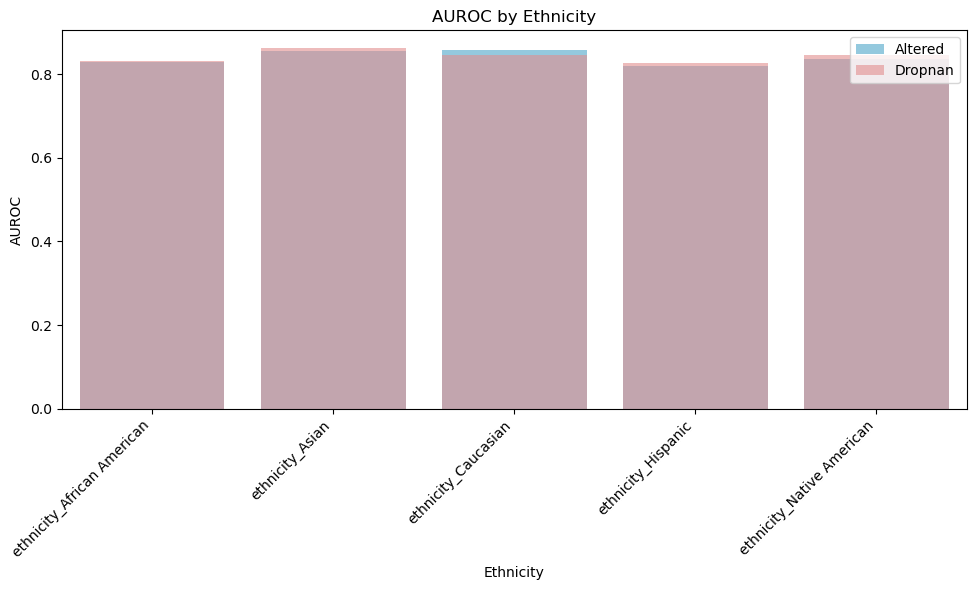

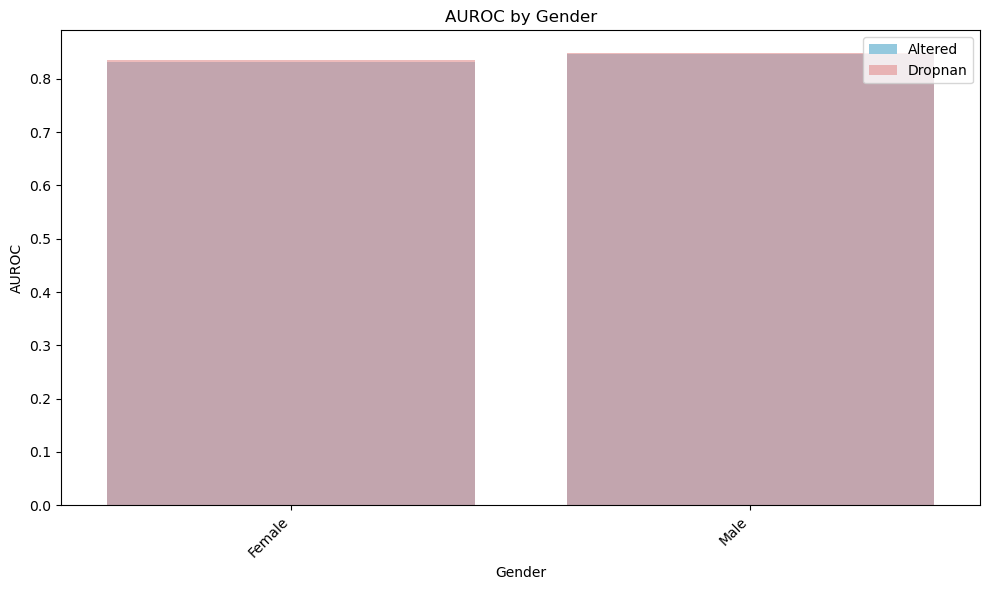

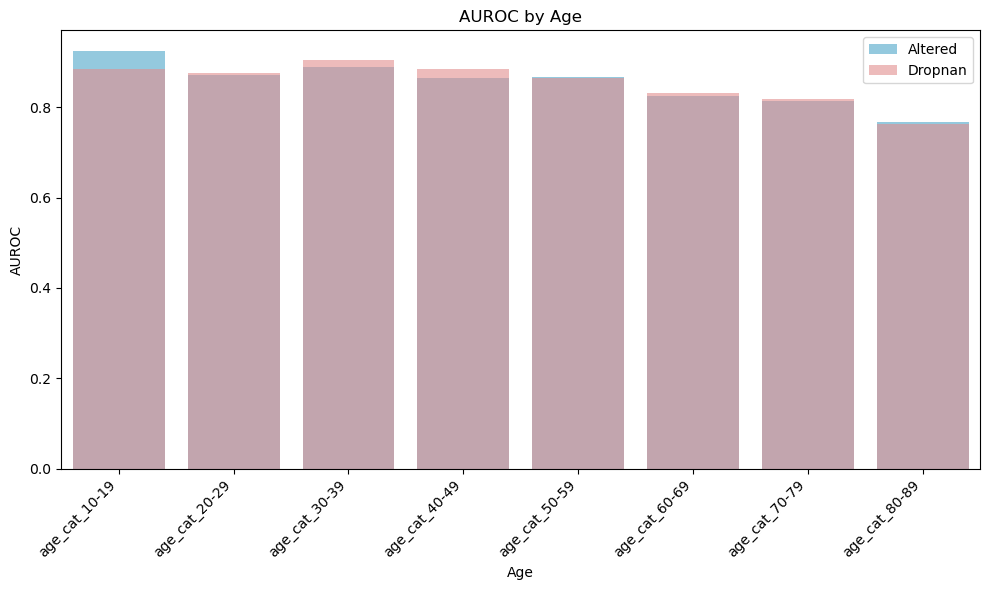

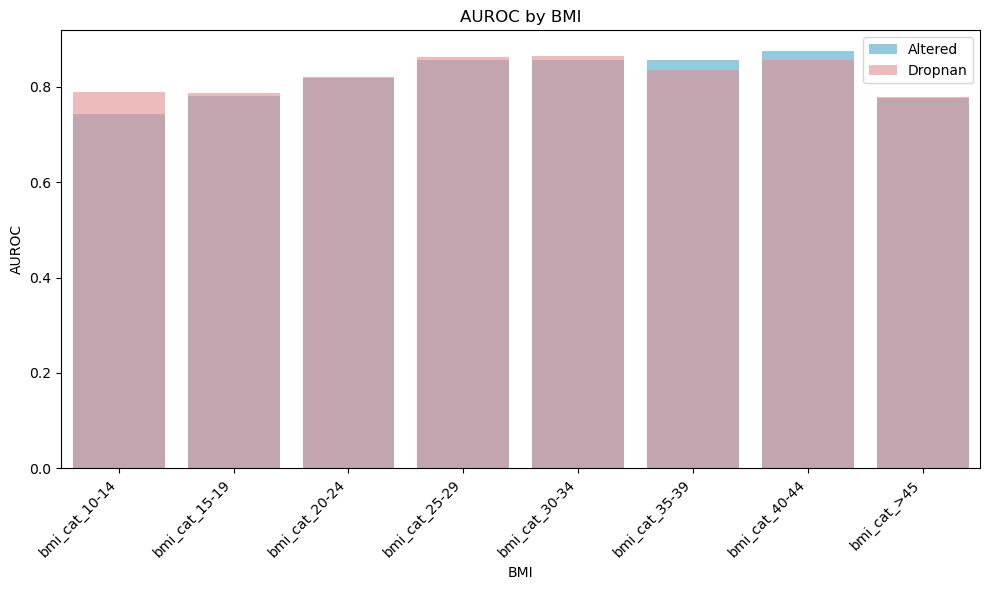

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_auroc_comparison(df, category, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category, y='AUROC_Altered', data=df, color='skyblue', label='Altered')
    sns.barplot(x=category, y='AUROC_Dropnan', data=df, color='lightcoral', alpha=0.6, label='Dropnan')
    plt.title(title)
    plt.ylabel('AUROC')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot AUROC comparisons
plot_auroc_comparison(ethnicity_df, 'Ethnicity', 'AUROC by Ethnicity')
plot_auroc_comparison(gender_df, 'Gender', 'AUROC by Gender')
plot_auroc_comparison(age_df, 'Age', 'AUROC by Age')
plot_auroc_comparison(bmi_df, 'BMI', 'AUROC by BMI')